In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
#from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )
from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact
#  from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics
from scipy.linalg import expm
from qulacs.gate import DenseMatrix, SparseMatrix
from qulacs import QuantumState
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc
from qumcmc.quantum_mcmc_qulacs_2 import quantum_enhanced_mcmc_2
from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact
import pickle

In [2]:
### BAS dataset energy model
### class to generate BAS dataset of arbitrary gridsize.
from itertools import permutations, product
class bas_dataset:
    def __init__(self, grid_size:int):
        self.grid_size=grid_size
        all_combn=[''.join(p) for p in product('01',repeat=self.grid_size)]
        all_combn.sort(key=lambda s: s.count('1'))
        all_combn.pop(0);all_combn.pop(-1)
        self.__all_combn=all_combn
        self.bas_dict=self.bars_and_stripes_dataset()
        self.dataset=self.bas_dict['stripes']+self.bas_dict['bars']
    
    def vertical_stripes(self):
        vert_stripes=[j*self.grid_size for j in self.__all_combn]
        return vert_stripes

    def horizontal_bars(self):
        hor_bars=[]
        for l in self.__all_combn:
            st=""
            for j in l:
                st=st+j*self.grid_size
            hor_bars.append(st)
        return hor_bars

    def bars_and_stripes_dataset(self):
        bas_dict={'stripes':self.vertical_stripes(),
            'bars':self.horizontal_bars()}
        return bas_dict

    ### create matrix of bitstring: meant for plotting
    def bit_string_to_2d_matrix(self,bitstring, array_shape:int):
        len_bs=len(bitstring)
        list_bs_int=[eval(i) for i in list(bitstring)]
        arr_bs=np.reshape(list_bs_int,(array_shape, array_shape))
        return arr_bs

    ### plot pixels
    def draw_pixelplot(self,bitstring:str,array_shape:int):
        im_array=self.bit_string_to_2d_matrix(bitstring,array_shape)
        plt.title(f"pixel plot for bitstring: {bitstring}")
        pixel_plot=plt.imshow(im_array,cmap='Greens',interpolation='nearest')
        plt.colorbar(pixel_plot)
        plt.show()

In [3]:
# hebbing learning
def hebbing_learning(list_bas_state:list):
    size=len(list_bas_state[0])
    wts=0
    for i in list_bas_state:
        arr=np.array([-1 if elem == "0" else 1 for elem in i])
        array=np.reshape(arr,(size,1));array_t=np.transpose(array)
        wts+=array@array_t
    wts=wts-len(list_bas_state)*np.identity(size)
    return wts

In [4]:
def define_random_spin_ising_model(n_spins:int,seed_val:int):
    # define the model # seed 4
    np.random.seed(seed_val)#(610358)# should always be in the same cell!  ## best seed -> 610358

    ## construct problem Hamiltonian ##
    shape_of_J=(n_spins,n_spins)

    ## defining J matrix (mutual 1-1 interaction)
    J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
    J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )
    J = 0.5 * (J + J.transpose() )
    J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

    # defining h
    h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)
    # instantiate the model
    model = IsingEnergyFunction(J, h, name= 'my_model')
    return model

In [5]:
# 
gridsize=3
bas=bas_dataset(grid_size=gridsize)
bas.dataset.sort()
# considering only stripes dataset
wt=hebbing_learning(bas.bas_dict['bars'])

# creating ising model for the bas stripes only dataset
n_spins=gridsize*gridsize
shape_of_J=(n_spins,n_spins)
J=-1*wt
h=np.zeros(n_spins)
model=IsingEnergyFunction(J,h,name=f'ising model BAS {n_spins}X{n_spins} bars only')
#model.model_summary()

            MODEL : my_model
Non-zero Interactions (J) : 45 / 45
Non-zero Bias (h) : 10 / 10
---------------------------------------------
Average Interaction Strength <|J|> :  0.6754600000000002
Average Bias Strength <|h|>:  0.35
alpha :  0.518519316996205
---------------------------------------------


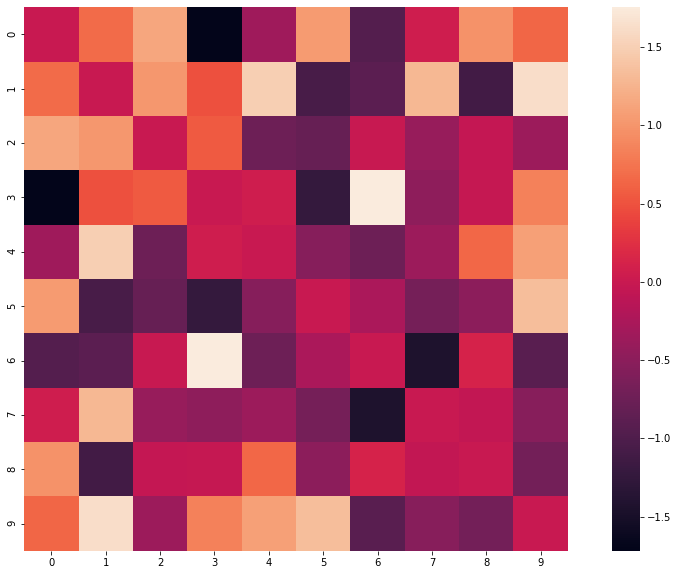

In [8]:
###
model=define_random_spin_ising_model(n_spins=10,seed_val=1)
#model.model_summary()

     MODEL : my_model |  beta : 1.5
Num Most Probable States : 9
Entropy : 2.534425964964983
---------------------------------------------


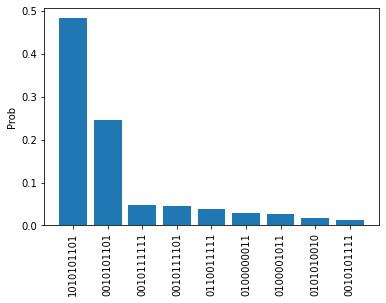

In [9]:
beta=1.5
## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

## get distribution from the model
bpd=exact_sampled_model.boltzmann_pd
exact_sampled_model.sampling_summary()

### Run mcmc chains

In [8]:
num_different_chains=10

In [9]:
seed_val_list=list(range(1,num_different_chains+1))
list_labels_bas=['cl','local','Q-MCMC:pauli_wt_1','Q-MCMC:pauli_wt_3']

In [ ]:
init_val_keys=dict(zip(list_labels_bas,[0,0,0,0]))
list_init_val_keys=[init_val_keys.copy() for i in range(1,num_different_chains+1)]
dict_mcmc_bas_gridsize_3=dict(zip(seed_val_list,list_init_val_keys))
print(dict_mcmc_bas_gridsize_3)

In [75]:
### case of mismatched hamiltonian
import random
n_spins=10
model=define_random_spin_ising_model(n_spins=n_spins,seed_val=1)# data for presentation.
beta=1.5
## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

## get distribution from the model
bpd=exact_sampled_model.boltzmann_pd
#exact_sampled_model.sampling_summary()


random_indices=random.sample(range(0,7),k=5)
J_pert=model.get_J
for j in random_indices:
    J_pert[j,j+1]=-1*J_pert[j,j+1]
h_pert=model.get_h
model_pert=IsingEnergyFunction(J_pert,h_pert,name=f'perturbed {n_spins}X{n_spins}')

# run mcmc for perturbed case
num_different_chains=10
seed_val_list=list(range(1,num_different_chains+1))
list_labels_bas=['Q-MCMC perturbed:pauli_wt_1']
init_val_keys=dict(zip(list_labels_bas,[0]))
list_init_val_keys=[init_val_keys.copy() for i in range(1,num_different_chains+1)]
dict_perturbed=dict(zip(seed_val_list,list_init_val_keys))

# quantum 1: single qubit pauli
for seed_val in range(1,num_different_chains+1):
    steps = 15000
    #list_labels.append('QMCMC; pauli_wt-1; gamma range=(0.2,0.6)')
    qamcmc_chain_1 =quantum_enhanced_mcmc_2(
        n_hops=steps,
        model=model_pert,
        temperature=1/beta,
        verbose=True,
        name= 'Q-MCMC perturbed:pauli_wt_1',
        gamma_range=(0.1,0.4)
    )
    #qumcm1_statistic = get_trajectory_statistics(qamcmc_chain_1, exact_sampled_model, verbose= False)
    dict_perturbed[seed_val]['Q-MCMC perturbed:pauli_wt_1']=qamcmc_chain_1





runnning quantum MCMC steps . ..:   0%|          | 5/15000 [00:00<05:53, 42.39it/s]

starting with:  0111010001 with energy: 0.051000000000000156


runnning quantum MCMC steps . ..:   0%|          | 10/15000 [00:00<02:40, 93.69it/s]

starting with:  1001000110 with energy: -0.4249999999999998


runnning quantum MCMC steps . ..:   0%|          | 5/15000 [00:00<05:20, 46.72it/s]

starting with:  1010111000 with energy: -2.4669999999999996


runnning quantum MCMC steps . ..:   0%|          | 7/15000 [00:00<04:38, 53.87it/s]

starting with:  0001100111 with energy: -1.239


runnning quantum MCMC steps . ..:   0%|          | 2/15000 [00:00<12:47, 19.53it/s]

starting with:  1011100001 with energy: -4.569000000000001


runnning quantum MCMC steps . ..:   0%|          | 10/15000 [00:00<02:40, 93.68it/s]

starting with:  1001110101 with energy: -3.809


runnning quantum MCMC steps . ..:   0%|          | 10/15000 [00:00<02:56, 84.96it/s]

starting with:  1110111100 with energy: -4.7490000000000006


runnning quantum MCMC steps . ..:   0%|          | 9/15000 [00:00<03:08, 79.64it/s]

starting with:  0001010011 with energy: -1.782999999999999


runnning quantum MCMC steps . ..:   0%|          | 8/15000 [00:00<03:21, 74.49it/s]

starting with:  1000001001 with energy: -10.375


runnning quantum MCMC steps . ..:   0%|          | 5/15000 [00:00<05:10, 48.23it/s]

starting with:  0001010001 with energy: 0.9910000000000003


runnning quantum MCMC steps . ..: 100%|██████████| 15000/15000 [03:05<00:00, 80.95it/s] 


In [83]:
print(dict_perturbed)

{1: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 2: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 3: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 4: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 5: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 6: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 7: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 8: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 9: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 10: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}}


In [84]:
name='dict_ising_model_num_spins_10_beta_1.5_seed_1_with_pert.pkl'
with open(name,'rb') as f:
    dict_mcmc_bas_gridsize_3=pickle.load(f)
print(dict_mcmc_bas_gridsize_3)

{1: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 2: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 3: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 4: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 5: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 6: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 7: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 8: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 9: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 10: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}}


In [82]:
# for i in range(1,11):
#     dict_mcmc_bas_gridsize_3[i]['Q-MCMC-pert']=dict_perturbed[i]['Q-MCMC:pauli_wt_1']

# dict_mcmc_bas_gridsize_3
# done

In [13]:
# list_labels=['cl',
#                 'QMCMC; pauli_wt-1; gamma range=(0.1,0.4)',
#                 'QMCMC; pauli_wt-2; gamma range=(0.1,0.4)','local']

In [12]:
for seed_val in range(1,num_different_chains+1):
    # classical uniform
    steps=15000
    #list_labels.append('classical uniform strategy')
    cl_chain =classical_mcmc(
        n_hops=steps,
        model=model,
        temperature=1/beta
    )
    cl_statistic = get_trajectory_statistics(cl_chain, exact_sampled_model, verbose= False)
    dict_mcmc_bas_gridsize_3[seed_val]['cl']=cl_chain

In [45]:
for seed_val in range(1,num_different_chains+1):
    # classical local
    steps=15000
    #list_labels.append('classical uniform strategy')
    cl_chain =classical_mcmc(
        n_hops=steps,
        model=model,
        temperature=1/beta,
        method='local'
    )
    cl_statistic = get_trajectory_statistics(cl_chain, exact_sampled_model, verbose= False)
    dict_mcmc_bas_gridsize_3[seed_val]['local']=cl_chain

In [13]:
# quantum 1: single qubit pauli
for seed_val in range(1,num_different_chains+1):
    steps = 15000
    #list_labels.append('QMCMC; pauli_wt-1; gamma range=(0.2,0.6)')
    qamcmc_chain_1 =quantum_enhanced_mcmc_2(
        n_hops=steps,
        model=model,
        temperature=1/beta,
        verbose=True,
        name= 'Q-MCMC:pauli_wt_1',
        gamma_range=(0.1,0.4)
    )
    qumcm1_statistic = get_trajectory_statistics(qamcmc_chain_1, exact_sampled_model, verbose= False)
    dict_mcmc_bas_gridsize_3[seed_val]['Q-MCMC:pauli_wt_1']=qamcmc_chain_1

runnning quantum MCMC steps . ..:   0%|          | 13/15000 [00:00<02:08, 116.65it/s]

starting with:  111100010 with energy: -16.0


runnning quantum MCMC steps . ..:   0%|          | 14/15000 [00:00<01:54, 130.44it/s]

starting with:  111010010 with energy: -16.0


runnning quantum MCMC steps . ..:   0%|          | 16/15000 [00:00<01:42, 145.86it/s]

starting with:  011000111 with energy: -48.0


runnning quantum MCMC steps . ..:   0%|          | 14/15000 [00:00<01:48, 137.57it/s]

starting with:  100000110 with energy: -8.0


runnning quantum MCMC steps . ..:   0%|          | 15/15000 [00:00<01:41, 148.00it/s]

starting with:  001001011 with energy: 16.0


runnning quantum MCMC steps . ..:   0%|          | 16/15000 [00:00<01:34, 158.21it/s]

starting with:  101100101 with energy: 16.0


runnning quantum MCMC steps . ..:   0%|          | 18/15000 [00:00<01:23, 178.82it/s]

starting with:  101000111 with energy: -48.0


runnning quantum MCMC steps . ..:   0%|          | 14/15000 [00:00<01:53, 132.57it/s]

starting with:  100010001 with energy: 24.0


runnning quantum MCMC steps . ..:   0%|          | 14/15000 [00:00<01:58, 126.66it/s]

starting with:  110001001 with energy: 16.0


runnning quantum MCMC steps . ..:   0%|          | 15/15000 [00:00<01:40, 148.62it/s]

starting with:  011111101 with energy: 8.0


runnning quantum MCMC steps . ..: 100%|██████████| 15000/15000 [01:48<00:00, 138.78it/s]


In [14]:
for seed_val in range(1,num_different_chains+1):
# quantum 2: 
    steps = 15000
    #list_labels.append('QMCMC; pauli_wt-2; gamma range=(0.2,0.6)')
    qamcmc_chain_2 =quantum_enhanced_mcmc_2(
        n_hops=steps,
        model=model,
        temperature=1/beta,
        verbose=True,
        pauli_weight_x_mixer=3,
        name='Q-MCMC:pauli_wt_3',
        gamma_range=(0.1,0.4)
    )
    dict_mcmc_bas_gridsize_3[seed_val]['Q-MCMC:pauli_wt_3']=qamcmc_chain_2
    qumcm2_statistic = get_trajectory_statistics(qamcmc_chain_2, exact_sampled_model, verbose= False)

runnning quantum MCMC steps . ..:   0%|          | 0/15000 [00:00<?, ?it/s]

starting with:  101110100 with energy: 16.0


runnning quantum MCMC steps . ..:   0%|          | 4/15000 [00:00<06:33, 38.12it/s]

starting with:  101111100 with energy: -8.0


runnning quantum MCMC steps . ..:   0%|          | 5/15000 [00:00<05:35, 44.66it/s]

starting with:  110100000 with energy: -8.0


runnning quantum MCMC steps . ..:   0%|          | 4/15000 [00:00<07:18, 34.17it/s]

starting with:  101010111 with energy: -8.0


runnning quantum MCMC steps . ..:   0%|          | 4/15000 [00:00<06:29, 38.52it/s]

starting with:  111111101 with energy: 0.0


runnning quantum MCMC steps . ..:   0%|          | 4/15000 [00:00<06:56, 36.01it/s]

starting with:  101110111 with energy: 8.0


runnning quantum MCMC steps . ..:   0%|          | 8/15000 [00:00<06:33, 38.14it/s]

starting with:  000101011 with energy: -16.0


runnning quantum MCMC steps . ..:   0%|          | 5/15000 [00:00<05:17, 47.21it/s]

starting with:  010110001 with energy: 16.0


runnning quantum MCMC steps . ..:   0%|          | 6/15000 [00:00<04:53, 51.11it/s]

starting with:  101101010 with energy: 16.0


runnning quantum MCMC steps . ..:   0%|          | 5/15000 [00:00<06:02, 41.40it/s]

starting with:  010011100 with energy: 16.0


runnning quantum MCMC steps . ..: 100%|██████████| 15000/15000 [06:17<00:00, 39.75it/s]


In [15]:
# name=f'''dict_simulations_BAS_bars_dataset_3x3.pkl'''
#with open(name,'wb') as f:
#         pickle.dump(dict_mcmc_bas_gridsize_3,f)

### plotting related

In [85]:
# this function would be useful for plotting curves
def plot_with_error_band(xval:list,y_list_of_list:list,label:str,
                            std_dev_multiplicative_factor:int=1,
                            alpha_for_plot:float=0.5):

    curve_of_mean_value=np.mean(y_list_of_list,axis=0)
    standard_dev_band=np.std(y_list_of_list,axis=0)
    plt.plot(xval,curve_of_mean_value,"-",label=label)
    plt.fill_between(xval,
                        curve_of_mean_value-standard_dev_band* std_dev_multiplicative_factor,
                        curve_of_mean_value+standard_dev_band* std_dev_multiplicative_factor,
                        alpha=alpha_for_plot)

In [52]:
#list_labels_bas=['cl']#['cl',  'Q-MCMC:pauli_wt_1', 'Q-MCMC:pauli_wt_3','local']

In [86]:
print(dict_mcmc_bas_gridsize_3[1])

{'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}


In [92]:
# KL divergence
list_kl_cl_bas_gridsize_3=[]
list_kl_qmcmc_pauli1_bas_gridsize_3=[]
list_kl_qmcmc_pauli3_bas_gridsize_3=[]
list_kl_local=[]
list_kl_pert=[]
for seed_val in tqdm(range(1,num_different_chains+1)):
    cl_chain=dict_mcmc_bas_gridsize_3[seed_val]['cl']
    local_chain=dict_mcmc_bas_gridsize_3[seed_val]['local']
    qamcmc_chain_1=dict_mcmc_bas_gridsize_3[seed_val]['Q-MCMC']
    #qamcmc_chain_2=dict_mcmc_bas_gridsize_3[seed_val]['Q-MCMC:pauli_wt_3']
    q_pert=dict_mcmc_bas_gridsize_3[seed_val]['Q-MCMC-pert']
    kldiv_c = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, cl_chain)
    kldiv_q1 = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, qamcmc_chain_1)
    #kldiv_q2 = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, qamcmc_chain_2)
    kldiv_local= calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, local_chain)
    kl_pert=calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, q_pert)
    #
    list_kl_cl_bas_gridsize_3.append(kldiv_c)
    list_kl_qmcmc_pauli1_bas_gridsize_3.append(kldiv_q1)
    #list_kl_qmcmc_pauli3_bas_gridsize_3.append(kldiv_q2)
    list_kl_local.append(kldiv_local)
    list_kl_pert.append(kl_pert)

100%|██████████| 10/10 [00:53<00:00,  5.39s/it]


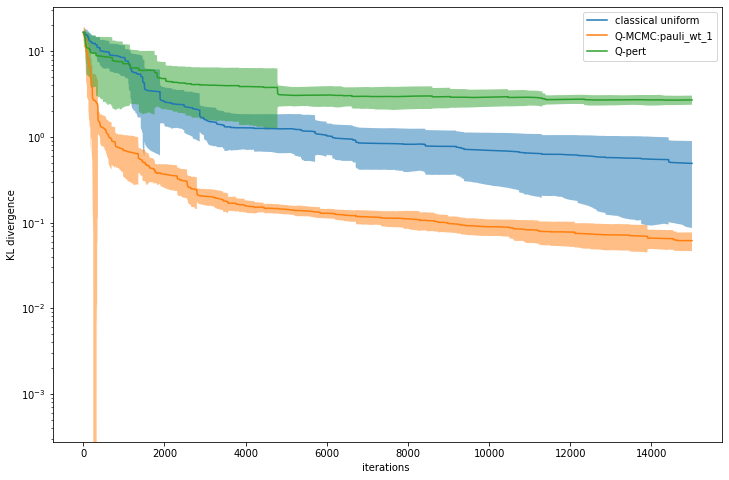

In [94]:
x=list(range(0,15000+1))
plt.figure(figsize=(12,8))
plot_with_error_band(x,list_kl_cl_bas_gridsize_3,label='classical uniform')
#plot_with_error_band(x,list_kl_local,label='local')
plot_with_error_band(x,list_kl_qmcmc_pauli1_bas_gridsize_3,label='Q-MCMC:pauli_wt_1')
#plot_with_error_band(x,list_kl_qmcmc_pauli3_bas_gridsize_3,label='Q-MCMC:pauli_wt_3')
plot_with_error_band(x,list_kl_pert,label='Q-pert')
plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
plt.legend()
# plt.savefig("KL_BAS_3X3_bars_only.pdf")
# plt.savefig("KL_BAS_3X3_bars_only.jpeg")
plt.show()

In [96]:
dict_mcmc_bas_gridsize_3[1]

{'cl': MCMCChain(),
 'local': MCMCChain(),
 'Q-MCMC': MCMCChain(),
 'Q-MCMC-pert': MCMCChain()}

In [97]:
list_mag_cl_bas_gridsize_3=[]
list_mag_qmcmc_pauli1_bas_gridsize_3=[]
list_mag_qmcmc_pauli3_bas_gridsize_3=[]
list_mag_local=[]
list_mag_pert=[]
magnetization_model = exact_sampled_model.get_observable_expectation(magnetization_of_state)

for seed_val in range(1,num_different_chains+1):
    cl_chain=dict_mcmc_bas_gridsize_3[seed_val]['cl']
    local_chain=dict_mcmc_bas_gridsize_3[seed_val]['local']
    qamcmc_chain_1=dict_mcmc_bas_gridsize_3[seed_val]['Q-MCMC']
    #qamcmc_chain_2=dict_mcmc_bas_gridsize_3[seed_val][list_labels_bas[3]]
    q_pert=dict_mcmc_bas_gridsize_3[seed_val]['Q-MCMC-pert']
    
    mag_c = calculate_runnning_magnetisation(cl_chain)
    mag_q1 = calculate_runnning_magnetisation(qamcmc_chain_1)
    #mag_q2 = calculate_runnning_magnetisation(qamcmc_chain_2)
    mag_local= calculate_runnning_magnetisation(local_chain)
    mag_pert =  calculate_runnning_magnetisation(q_pert)
    #
    list_mag_cl_bas_gridsize_3.append(mag_c)
    list_mag_qmcmc_pauli1_bas_gridsize_3.append(mag_q1)
    #list_mag_qmcmc_pauli3_bas_gridsize_3.append(mag_q2)
    list_mag_local.append(mag_local)
    list_mag_pert.append(mag_pert)

  4%|▍         | 674/15000 [00:00<00:02, 6667.88it/s]

100%|██████████| 15000/15000 [00:25<00:00, 599.16it/s]


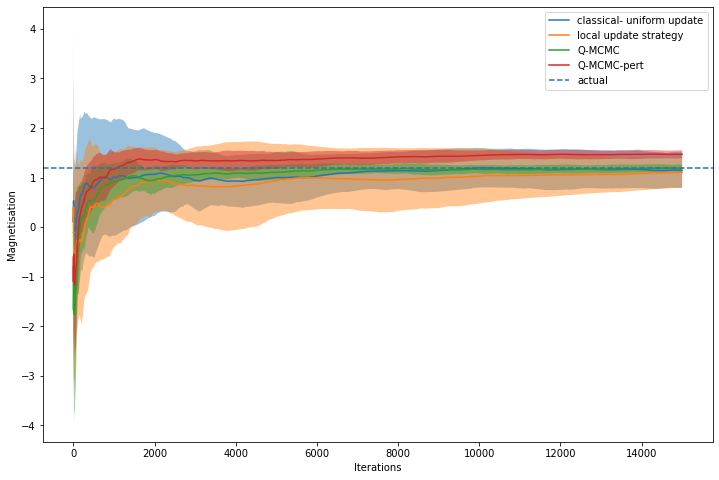

In [109]:
fig, ax1 = plt.subplots(figsize=(12,8))

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.55, 0.2, 0.25, 0.25]
#ax2 = fig.add_axes([left, bottom, width, height])

x=list(range(0,15000))

# ax1 figure
mean_mag_cl=np.mean(list_mag_cl_bas_gridsize_3,axis=0);std_cl=np.std(list_mag_cl_bas_gridsize_3,axis=0)
ax1.plot(x,mean_mag_cl,label='classical- uniform update')
ax1.fill_between(x,mean_mag_cl-std_cl,mean_mag_cl+std_cl,alpha=0.45)

mean_mag_local=np.mean(list_mag_local,axis=0)
std_local=np.std(list_mag_local,axis=0)
ax1.plot(x,mean_mag_local,label='local update strategy')
ax1.fill_between(x,mean_mag_local-std_local,mean_mag_local+std_local,alpha=0.45)


mean_mag_qmcmc1=np.mean(list_mag_qmcmc_pauli1_bas_gridsize_3,axis=0)
std_q1=np.std(list_mag_qmcmc_pauli1_bas_gridsize_3,axis=0)
ax1.plot(x,mean_mag_qmcmc1,label='Q-MCMC')#list_labels_bas[2])
ax1.fill_between(x,mean_mag_qmcmc1-std_q1,mean_mag_qmcmc1+std_q1,alpha=0.45)

mean_mag_pert=np.mean(list_mag_pert,axis=0)
std_qpert=np.std(list_mag_pert,axis=0)
ax1.plot(x,mean_mag_pert,label='Q-MCMC-pert')
ax1.fill_between(x,mean_mag_pert-std_qpert,mean_mag_pert+std_qpert,alpha=0.45)

# mean_mag_qmcmc2=np.mean(list_mag_qmcmc_pauli3_bas_gridsize_3,axis=0)
# std_q2=np.std(list_mag_qmcmc_pauli3_bas_gridsize_3,axis=0)
# ax1.plot(x,mean_mag_qmcmc2,label=list_labels_bas[3])
# ax1.fill_between(x,mean_mag_qmcmc2-std_q2,mean_mag_qmcmc2+std_q2,alpha=0.5)



ax1.axhline(magnetization_model, label= 'actual',linestyle='--')
ax1.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Magnetisation")


# ax1.axhline(magnetization_model, label= 'actual',linestyle='--')
# ax1.legend()
# ax1.set_xlabel("Iterations")
# ax1.set_ylabel("Magnetisation")

#ax2 figure
# ax2.plot(x,mean_mag_cl,label=list_labels_bas[0])
# ax2.fill_between(x,mean_mag_cl-std_cl,mean_mag_cl+std_cl,alpha=0.5)
# ax2.plot(x,mean_mag_cl,label='local')##
# ax2.fill_between(x,mean_mag_local-std_local,mean_mag_cl+std_local,alpha=0.5)###
# # ax2.plot(x,mean_mag_qmcmc1,label=list_labels_bas[1])
# # ax2.fill_between(x,mean_mag_qmcmc1-std_q1,mean_mag_qmcmc1+std_q1,alpha=0.5)
# ax2.plot(x,mean_mag_qmcmc2,label=list_labels_bas[2])
# ax2.fill_between(x,mean_mag_qmcmc2-std_q2,mean_mag_qmcmc2+std_q2,alpha=0.5)
# ax2.axhline(magnetization_model, label= 'actual',linestyle='--')
# ax2.set_xlim([10000,14000])
# ax2.set_ylim([2,0])
# ax2.set_xlabel("Iterations")
# ax2.set_ylabel("Magnetisation")

fig.savefig(f"Magnetisation_10_spins_for_presentation_with_pert.pdf")# done
#fig.savefig(f"Magnetisation_BAS_{gridsize}_bars_only.jpeg")
plt.show()

In [110]:
check=dict_mcmc_bas_gridsize_3[1]

In [111]:
list_keys=list(dict_mcmc_bas_gridsize_3[1].keys())

In [115]:
# plt.figure(figsize=(15,10))
# labels=['classical- uniform update','local','Q-MCMC','Q-MCMC-pert']
# for i in range(0,4):
#     a=dict_mcmc_bas_gridsize_3[1][list_keys[i]]
#     plt.subplot(2,2,i+1)
#     xval=list(range(1000,2000))
#     plt.plot(xval,a.markov_chain[1000:2000],label=labels[i])
#     # plt.plot(a.markov_chain,label=labels[i])
#     plt.legend()

In [21]:
# magnetisation
# magnetization_model = exact_sampled_model.get_observable_expectation(magnetization_of_state)
# magnetization_c = calculate_runnning_magnetisation(cl_chain)
# magnetization_q1 = calculate_runnning_magnetisation(qamcmc_chain_1)
# magnetization_q2 = calculate_runnning_magnetisation(qamcmc_chain_2)

# plt.figure(figsize=(10,8))
# plt.plot(magnetization_c, label= list_labels[0])
# plt.plot(magnetization_q1, label= list_labels[1])
# plt.plot(magnetization_q2, label= list_labels[2])
# plt.axhline(magnetization_model, label= 'original',linestyle='--')
# plt.xlabel("iterations")
# plt.ylabel("magnetisation")
# plt.legend()
# plt.show()

In [116]:
list_keys=list(dict_mcmc_bas_gridsize_3[1].keys())
list_keys

['cl', 'local', 'Q-MCMC', 'Q-MCMC-pert']

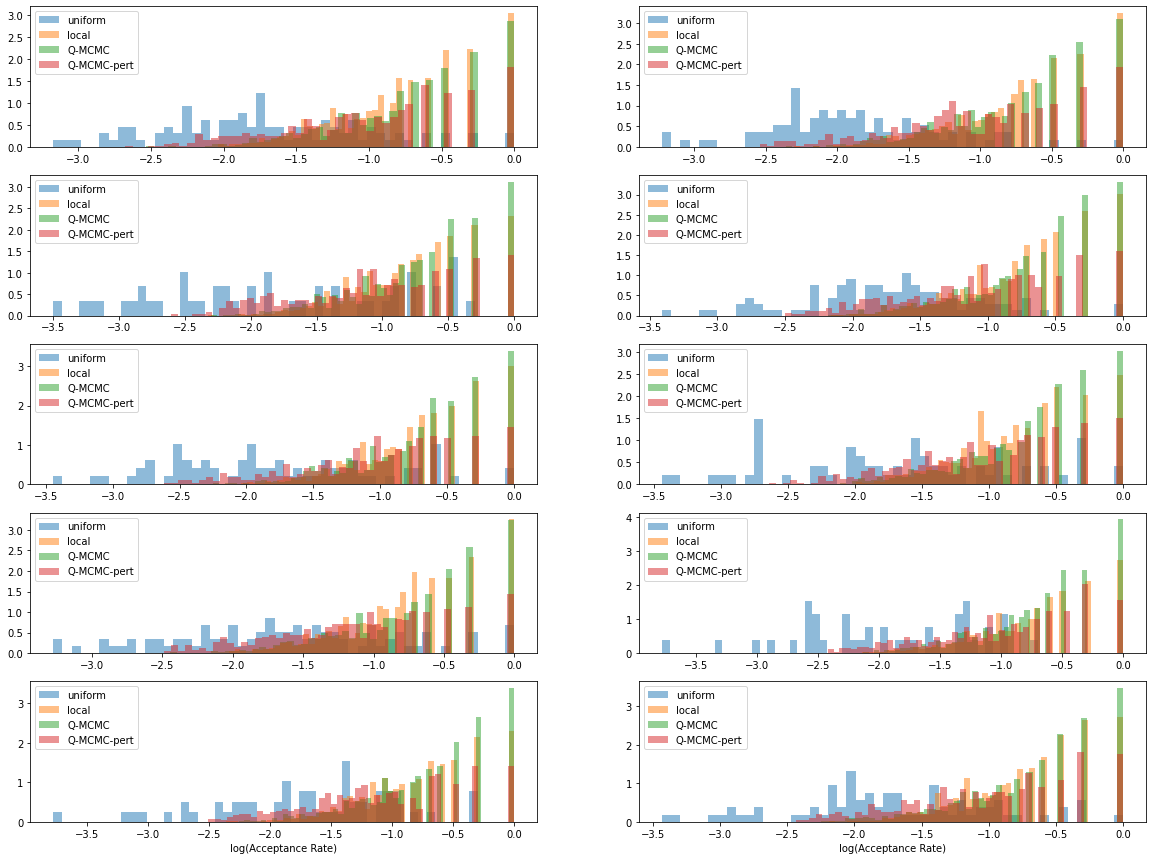

In [120]:
### plots

# acceptance probability
plt.figure(1,figsize=(20,15))
for seed_val in range(1,num_different_chains+1):
    cl_chain=dict_mcmc_bas_gridsize_3[seed_val][list_keys[0]]
    local_chain=dict_mcmc_bas_gridsize_3[seed_val]['local']
    qamcmc_chain_1=dict_mcmc_bas_gridsize_3[seed_val]['Q-MCMC']
    q_pert=dict_mcmc_bas_gridsize_3[seed_val]['Q-MCMC-pert']
    #qamcmc_chain_2=dict_mcmc_bas_gridsize_3[seed_val][list_labels_bas[3]]
    
    cl_statistics=get_trajectory_statistics(cl_chain,exact_sampled_model)
    qumcm1_statistics=get_trajectory_statistics(qamcmc_chain_1,exact_sampled_model)
    local_statistics=get_trajectory_statistics(local_chain,exact_sampled_model)
    qpert_statistics=get_trajectory_statistics(q_pert,exact_sampled_model)
    #qumcm2_statistic=get_trajectory_statistics(qamcmc_chain_2,exact_sampled_model)
    
    plt.subplot(5,2,seed_val)
    plt.hist(np.log10(cl_statistics['acceptance_prob']),
            label= 'uniform' ,alpha= 0.5, 
            bins= 50,density=True)
    plt.hist(np.log10(local_statistics['acceptance_prob']),
            label= 'local' ,alpha= 0.5, 
            bins= 50,density=True)
    plt.hist(np.log10(qumcm1_statistics['acceptance_prob']),
                label='Q-MCMC' , alpha= 0.5, bins= 50,density=True)
    # plt.hist(np.log10(qumcm2_statistic['acceptance_prob']), label= list_labels_bas[3] , alpha= 0.5, bins= 40,density=True)
    plt.hist(np.log10(qpert_statistics['acceptance_prob']), label= 'Q-MCMC-pert', alpha= 0.5, bins= 50,density=True)
    if seed_val==9 or seed_val==10:
        plt.xlabel("log(Acceptance Rate)")
    plt.legend()
plt.savefig("Acceptance_rate_plot_10_spins_for_presentation_with_pert.pdf")
plt.savefig("Acceptance_rate_plot_for_presentation_with_pert.jpeg")
plt.show()

# # energy plot
    # plt.figure(2,figsize=(10,10))
    # plt.hist(cl_statistic['energy'],label= list_labels[0] ,alpha= 0.8, bins= 20)
    # plt.hist(qumcm1_statistic['energy'],
    #             label=list_labels[1]  , alpha= 0.8, bins= 20)
    # plt.hist(qumcm2_statistic['energy'],
    #             label= list_labels[2] , alpha= 0.8, bins= 20)
    # plt.xlabel("Energy-Difference Statistics")
    # plt.legend()
    # plt.show()

# # Hamming distance
    #plt.figure(1,figsize=(10,10))
    # plt.subplot(5,2,seed_val)
    # plt.hist(cl_statistic['hamming'],label= list_labels_bas[0] ,alpha= 0.8, bins= 20)
    # plt.hist(qumcm1_statistic['hamming'],
    #             label= list_labels_bas[1] , alpha= 0.8, bins= 20)
    # plt.hist(qumcm2_statistic['hamming'],
    #             label= list_labels_bas[2] , alpha= 0.8, bins= 20)
    # plt.xlabel("Hamming-Distance Statistics")
    # plt.legend()
    # plt.show()

In [23]:
# distributions_to_plot = [exact_sampled_model.boltzmann_pd, cl_chain.get_accepted_dict(normalize= True), 
#                         qamcmc_chain_1.get_accepted_dict(normalize= True),qamcmc_chain_2.get_accepted_dict(normalize= True)
#                         ]
# plot_multiple_bargraphs(distributions_to_plot, ['exact']+list_labels, 
#                                                 list_normalise= [False, False, False,False], 
#                                                 plot_first_few=15)